<a href="https://colab.research.google.com/github/feliciapedwards/TensorFlow-with-Laurence-Moroney/blob/master/Course2Week3_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install Tensorflow==2.0

     |████████████████████████████████| 86.3MB 65kB/s 
     |████████████████████████████████| 450kB 37.5MB/s 
     |████████████████████████████████| 3.8MB 31.9MB/s 
     |████████████████████████████████| 81kB 9.3MB/s 
ERROR: tensorboard 2.0.2 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalle

In [1]:
import os

#Let's us evaluate the layers so we can determine which ones we want to use or retrain
from tensorflow.keras import layers
from tensorflow.keras import Model

#This will bring in the parameters of the pretrained model inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), #Desired shape of our model
                                include_top = False, #Ignore connected first layer
                                weights = None) #We don't want the built-in weights, but the weights from pretrained model

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()
# all layers have a name, here we pull layer mixed7 - the output of convolutions that are 7x7 from inception
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-01-05 09:08:46--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   107MB/s    in 0.8s    

2020-01-05 09:08:47 (107 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


In [0]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
# We define our new model using the output of the mixed7 layer, defined as last_ouput
x = layers.Flatten()(last_output) 

# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)

# Add a dropout rate of 0.2
# It's a regularization technique, helps prevent overfitting, especially for computer vision
# 20% dropout rate seems to be standard, but I have seen people use up to 70% 
x = layers.Dropout(0.2)(x)                  

# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


In [5]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import zipfile

local_zip = '//tmp/cats_and_dogs_filtered.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/tmp')
zip_ref.close()

# Define our example directories and files
base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directories with images
train_cats_dir = os.path.join(train_dir, 'cats') 
train_dogs_dir = os.path.join(train_dir, 'dogs') 
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

--2020-01-05 09:09:24--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.11.128, 2607:f8b0:400c:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.11.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   235MB/s    in 0.3s    

2020-01-05 09:09:24 (235 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 615s - loss: 0.5094 - acc: 0.7655 - val_loss: 0.2310 - val_acc: 0.9290
Epoch 2/20
100/100 - 612s - loss: 0.3777 - acc: 0.8295 - val_loss: 0.1855 - val_acc: 0.9490
Epoch 3/20
100/100 - 611s - loss: 0.3679 - acc: 0.8450 - val_loss: 0.2654 - val_acc: 0.9440
Epoch 4/20
100/100 - 616s - loss: 0.3206 - acc: 0.8680 - val_loss: 0.2489 - val_acc: 0.9520
Epoch 5/20
100/100 - 614s - loss: 0.2927 - acc: 0.8765 - val_loss: 0.3884 - val_acc: 0.9370
Epoch 6/20
100/100 - 611s - loss: 0.3137 - acc: 0.8760 - val_loss: 0.3788 - val_acc: 0.9420
Epoch 7/20
100/100 - 614s - loss: 0.2830 - acc: 0.8775 - val_loss: 0.4675 - val_acc: 0.9400
Epoch 8/20
100/100 - 610s - loss: 0.3004 - acc: 0.8820 - val_loss: 0.3706 - val_acc: 0.9420
Epoch 9/20
100/100 - 610s - loss: 0.2859 - acc: 0.8885 - val_loss: 0.3585 - val_acc: 0.9470
Epoch 10/20
100/100 - 611s - loss: 0.3166 - acc: 0.8690 - val_loss: 0.4289 - val_acc: 0.9380
Epoch 11/20
100/100 - 617s - loss: 0.2935 - acc: 0.8860 - val_loss: 0.2618 - va

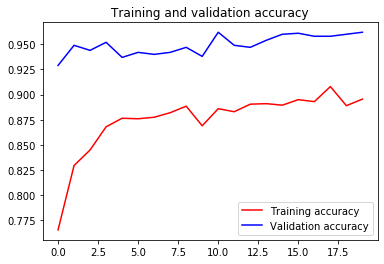

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()